# Autocorrelation analysis of some descriptor computed along centreline

In [190]:
import numpy as np
import matplotlib.pyplot as plt
import os 

from yaml import load
from yaml.loader import Loader


from helpers.descriptors import Section
from scipy.spatial import distance_matrix

In [166]:
from scipy.spatial import cKDTree

In [6]:
BASENAME = "02_GrotteDeLaCascadeDeMotiers"


fp = f"../../real_data/{BASENAME}/params.yaml"

params = load(open(fp), Loader)

GLOBAL_SHIFT = np.array(params["alignment"]["globalShift"])

SECTION = "1"
PASSAGE = "ThirdGallery"

In [7]:
plane_origins = np.loadtxt(f"../../real_data/{BASENAME}/process/planes_as_vectors/{PASSAGE}_{SECTION}_Planes_Origin.txt") + GLOBAL_SHIFT
plane_vectors =  np.loadtxt(f"../../real_data/{BASENAME}/process/planes_as_vectors/{PASSAGE}_{SECTION}_Planes.txt")

curvilinear_pos = np.linalg.norm(np.diff(plane_origins, axis = 0), axis = 1)

In [14]:
fp_list = os.listdir(f"../../real_data/{BASENAME}/process/sections_as_polylines/")

sections_fp = [fp for fp in fp_list if f"{PASSAGE}_{SECTION}_reordered_2d" in fp] 

In [17]:
sections = [Section(np.loadtxt(os.path.join(f"../../real_data/{BASENAME}/process/sections_as_polylines/", section_fp)),
                                            "ok", 
                                            curvilinear_pos= n / 2, 
                                            from3d=False) 
                                            for n, section_fp in enumerate(sections_fp)]

In [18]:
for section in sections:
    section.compute_descriptors()
    section.fitEllipse()

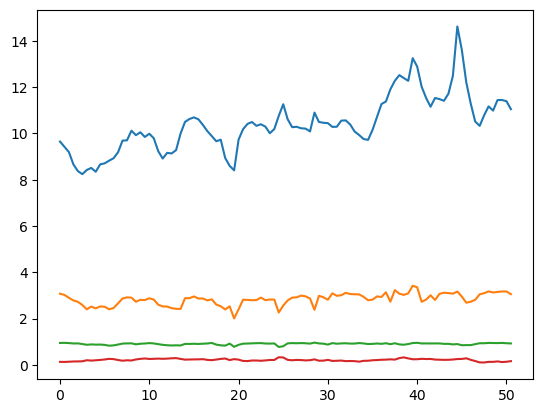

In [136]:
fig, ax = plt.subplots()
xi =  np.array([s.curvilinear_pos for s in sections])
areas =  np.array([s.area for s in sections])
dhs =  [s.hydraulic_diameter for s in sections]
solidities =  [s.solidity for s in sections]
distances_to_ellipse =  [s.mean_dist_to_ellipse for s in sections]

ax.plot(xi, areas)
ax.plot(xi, dhs)
ax.plot(xi, solidities)
ax.plot(xi, distances_to_ellipse)

In [202]:
# Moran's I global autocorrelation statistic. 
# spatially lagged value on y axis. # original value on the x axis. 

def MoranScatterPlot(series, ax):
    series_std = np.array(series) - np.mean(series)

    ax.scatter(series_std, np.roll(series_std, 2), marker ="o", color = "None", edgecolors="dodgerblue")
    ax.axhline(0,ls= "--", color = "k")
    ax.axvline(0,ls ="--", color = "k")
    ax.set_aspect("equal")


In [203]:
def returnmoransI(y, xi):
     y = np.array(y).copy()
     y_bar = y - y.mean()
     points = np.vstack([np.zeros(len(xi)), xi]).T
     pairwise_dist = distance_matrix(points, points)
     for i in range(pairwise_dist.shape[0]):
          pairwise_dist[i,i] = np.inf

     # inverse distance weighting. 
     W = 1.0 / pairwise_dist
     W /= W.sum(axis=0)
     moransI = y_bar.T @ W @ y_bar / (y_bar.T @ y_bar)

     return moransI



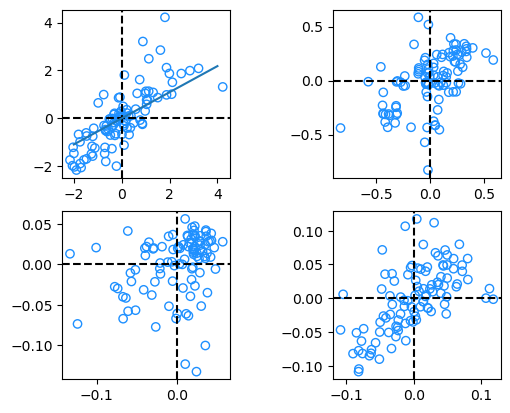

In [204]:
fig, axes = plt.subplots(2, 2)
MoranScatterPlot(areas, ax=axes[0, 0])
axes[0,0].plot(np.linspace(-2, 4), returnmoransI(areas, xi)*np.linspace(-2, 4))
MoranScatterPlot(dhs, ax=axes[0, 1])
MoranScatterPlot(solidities, ax=axes[1, 0])
MoranScatterPlot(distances_to_ellipse, ax=axes[1, 1])

In [192]:
returnmoransI(areas, xi)

0.5455497055713507

In [163]:
def ACF(y):
    y = np.array(y).copy()
    y_bar = y - np.mean(y)
    acf = []
    for k in range(1, len(y)):
        corr_k = y_bar[:-k].T @ y_bar[k:] / (y_bar.T @ y_bar)
    
        acf.append(corr_k)

    return np.array(acf)

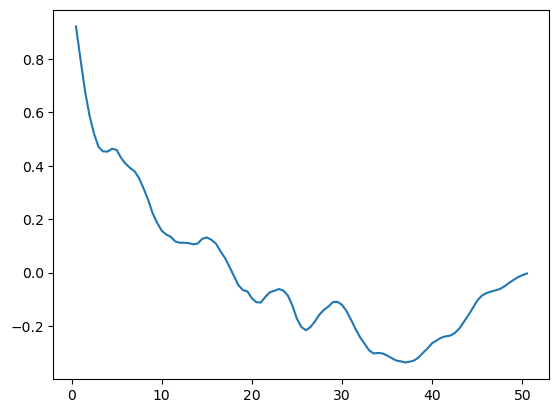

In [175]:
plt.plot(xi[1:], ACF(areas))

In [205]:
pip install scikit-gstat

  Obtaining dependency information for scikit-gstat from https://files.pythonhosted.org/packages/04/32/b95f741b6998f620d7caf567d0b04e4178baba145e783099b2769fc7b2e1/scikit_gstat-1.0.16-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/708.3 kB ? eta -:--:--
    --------------------------------------- 10.2/708.3 kB ? eta -:--:--
   ---- ----------------------------------- 81.9/708.3 kB 1.5 MB/s eta 0:00:01
   -------- ------------------------------- 143.4/708.3 kB 1.4 MB/s eta 0:00:01
   ----------- ---------------------------- 204.8/708.3 kB 1.2 MB/s eta 0:00:01
   --------------- ------------------------ 276.5/708.3 kB 1.3 MB/s eta 0:00:01
   ------------------- -------------------- 337.9/708.3 kB 1.2 MB/s eta 0:00:01
   ----------------------- ---------------- 409.6/708.3 kB 1.3 MB/s eta 0:00:01
   ------------------------ --------------- 440.3/708.3 kB 1.3 MB/s eta 0:00:01
   ---------------------------- ----------- 501.8/708.3 kB 1.3 MB/s eta 0:00:01
   -----

In [208]:
import skgstat as skg

In [272]:
# the data functions return a dict of 'sample' and 'description'

V = skg.Variogram(coordinates=xi, values=areas, maxlag=0.9, model="matern")
print(V)

matern Variogram
----------------
Estimator:         matheron
Effective Range:   45.45
Sill:              3.38
Nugget:            0.00
        


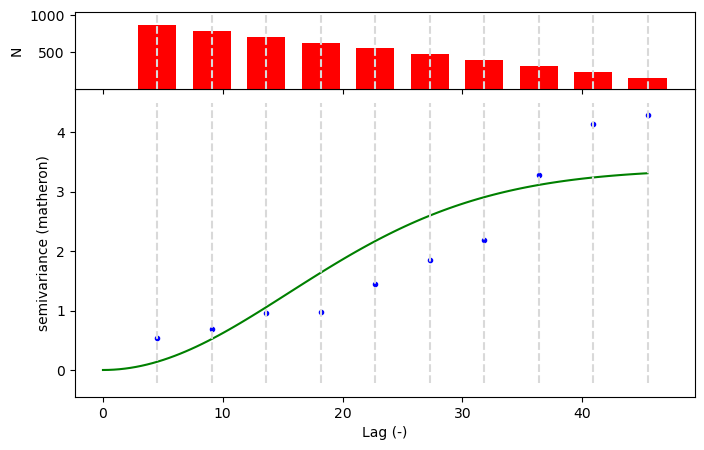

In [273]:
V.plot()
plt.show()

c:\Users\tangr\anaconda3\Lib\site-packages\skgstat\plotting\variogram_scattergram.py:57: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


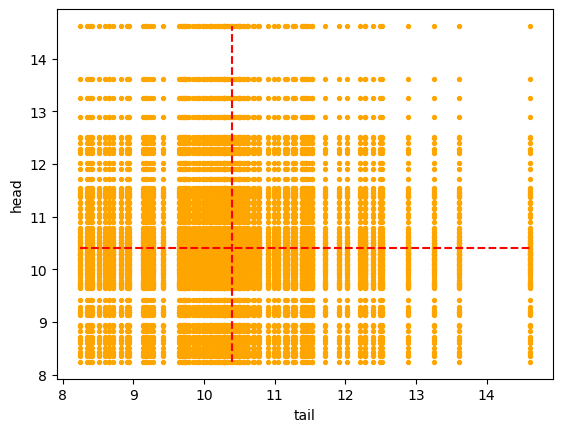

In [265]:
V.scattergram()
plt.show()

In [ ]:
# ellipse of inertia. meeting in Bojan, Sergio, to talk about the descriptors, especially the best fit ellipse. and how it is currently calculated. 
# show some examples of ellipse and trench. Maybe score it better ? 
# 11th or 18th March new meeting Karst. 